<a href="https://colab.research.google.com/github/kang9366/PetKeeper_DeepLearning/blob/main/eye_disease_classification_model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/결막염'

In [4]:
files_true = os.listdir(path + '/conjunctivitis')
files_false = os.listdir(path + '/normal')

for file in files_true:
  if file[-4:] == 'json':
    os.remove(path+'/conjunctivitis/'+file)

for file in files_false:
  if file[-4:] == 'json':
    os.remove(path+'/normal/'+file)

In [5]:
files_true = os.listdir(path + '/conjunctivitis')
files_false = os.listdir(path + '/normal')

data = {'class':[],'num':[]}
data['class'] += ['conjunctivitis', 'normal']
data['num'] += [len(files_false), len(files_true)]

df = pd.DataFrame(data)
df

,class,num
0,conjunctivitis,1200
1,normal,1203


<Axes: xlabel='class', ylabel='num'>

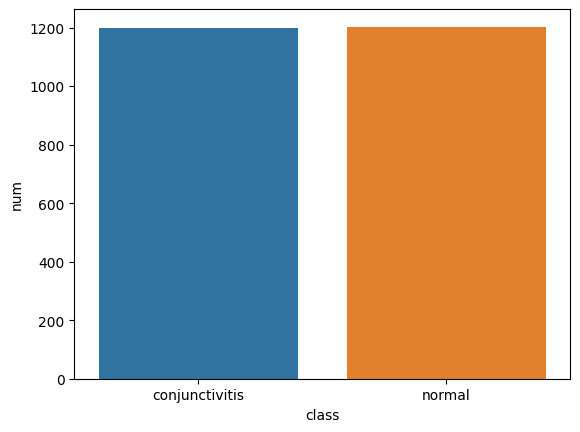

In [6]:
sns.barplot(x=df['class'],y=df['num'])

/content/drive/MyDrive/결막염/conjunctivitis/crop_D56_12c97d02-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D31_29d5e05b-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D46_0c2f3b25-60a5-11ec-8402-0a7404972c70.png
/content/drive/MyDrive/결막염/conjunctivitis/crop_D28_18a23a23-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D8_29afc1b4-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/conjunctivitis/crop_D39_18b1e19a-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D27_0c3890bf-60a5-11ec-8402-0a7404972c70.png
/content/drive/MyDrive/결막염/conjunctivitis/crop_D55_18ae1e0b-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D44_29f79bf8-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/결막염/normal/crop_D5_29a1e5a7-60a5-11ec-8402-0a7404972c70.jpg


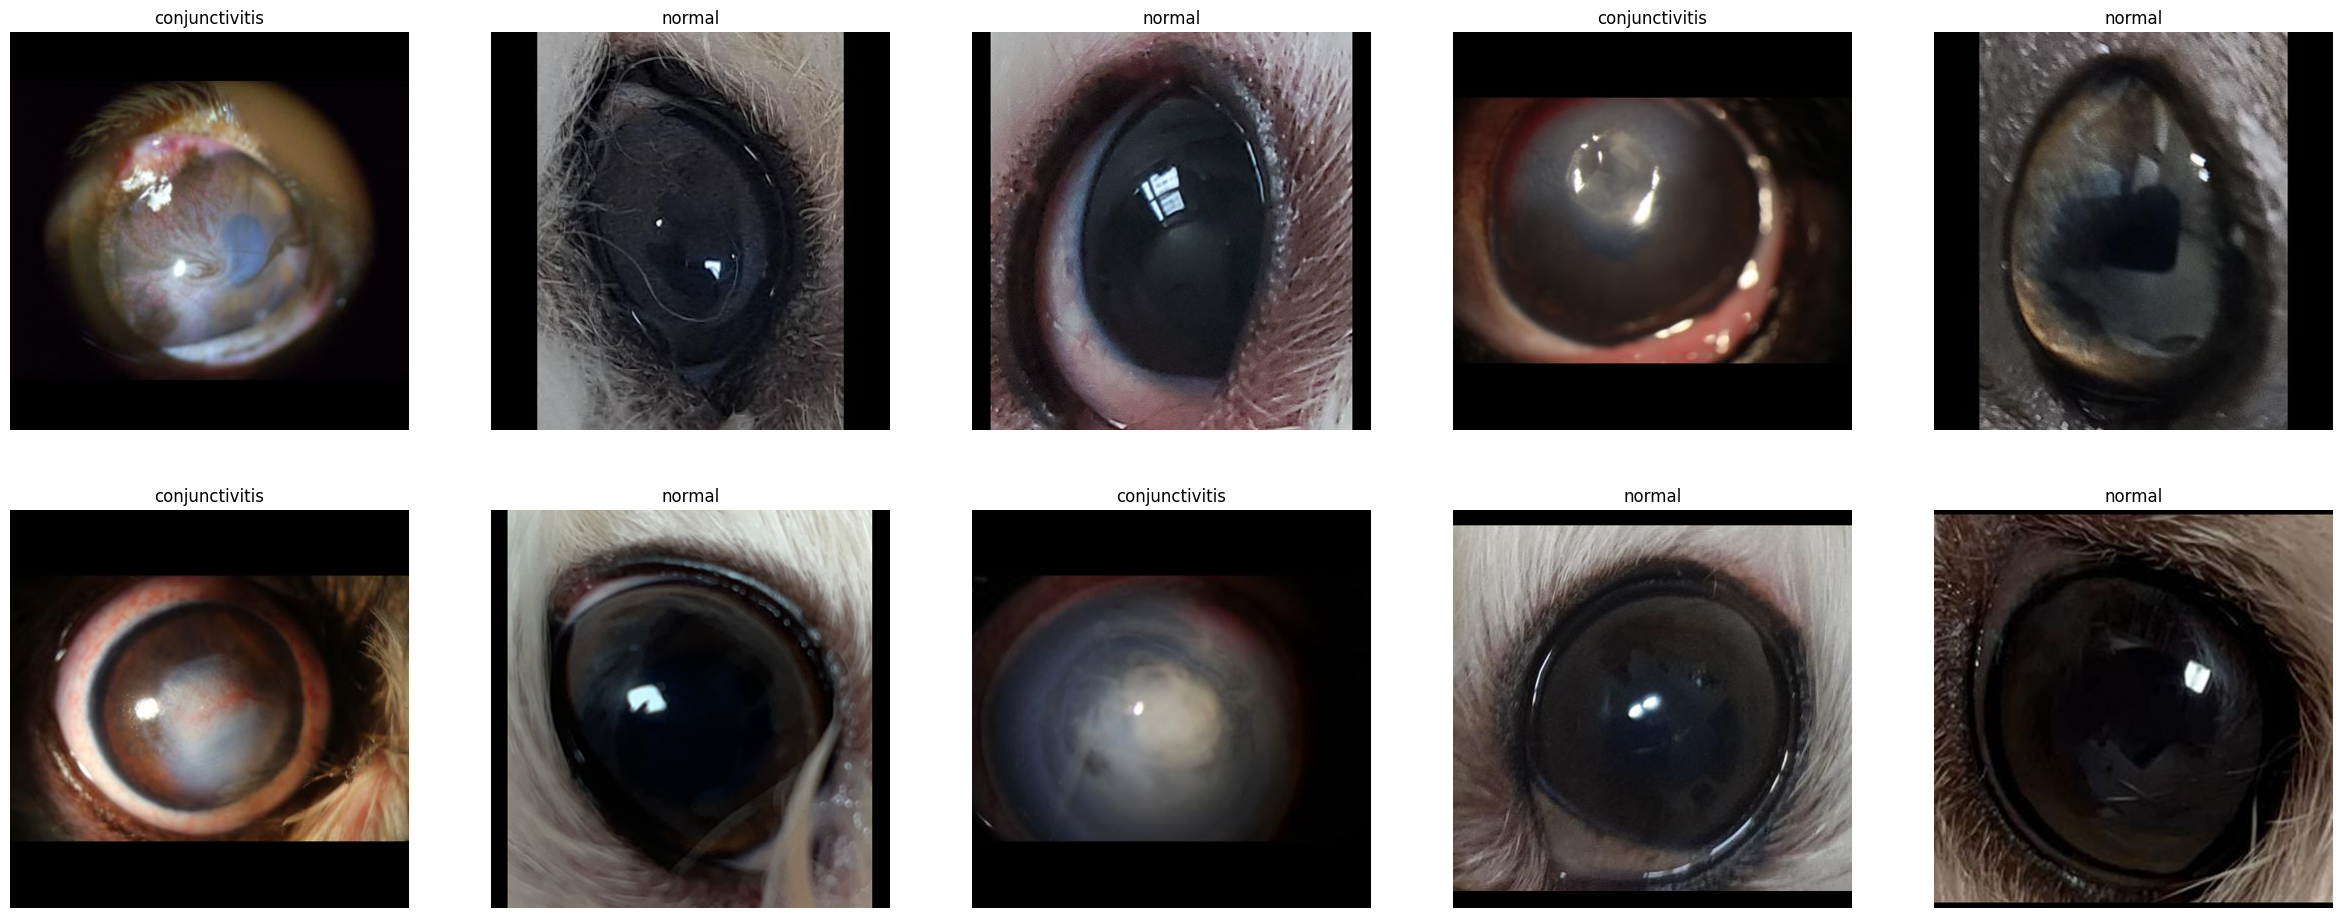

In [7]:
classes = os.listdir(path)

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,1)                    # getting the class
    images = os.listdir(path+'/'+classes[i])
    j = random.randint(0,1000)                  # getting the image
    image = cv2.imread(path+'/'+classes[i]+'/'+images[j])
    print(path+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [27]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [44]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

dataset = ImageFolder('/content/drive/MyDrive/결막염',
                      transform=transforms.Compose([transforms.RandomCrop(96), transforms.ToTensor()]))

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train, validation = random_split(dataset, [train_size, test_size])

In [45]:
print(len(train))
print(len(validation))

1682
721


In [46]:
train_dl = DataLoader(train, batch_size=32, shuffle=True)
val_dl = DataLoader(validation, batch_size=32, shuffle=True)

In [50]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [51]:
# Basic Conv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [52]:
# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )
        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )
        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )
        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=10):
    return MobileNet(alpha, num_classes)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 224, 224)).to(device)
model = mobilenet(alpha=1).to(device)
output = model(x)
print('output size:', output.size())

output size: torch.Size([3, 10])


In [54]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
            ReLU6-10         [-1, 64, 112, 112]               0
        Depthwise-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            ReLU6-14           [-1, 64,

In [55]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [56]:
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 0.716896, val loss: 0.553343, accuracy: 70.46, time: 0.8637 min
----------
Epoch 1/29, current lr= 0.01
train loss: 0.516421, val loss: 0.604809, accuracy: 74.06, time: 1.6875 min
----------
Epoch 2/29, current lr= 0.01
train loss: 0.477660, val loss: 0.563761, accuracy: 76.98, time: 2.5257 min
----------
Epoch 3/29, current lr= 0.01
Copied best model weights!
train loss: 0.450361, val loss: 0.517240, accuracy: 73.23, time: 3.3850 min
----------
Epoch 4/29, current lr= 0.01
train loss: 0.451143, val loss: 0.944948, accuracy: 57.42, time: 4.2577 min
----------
Epoch 5/29, current lr= 0.01
train loss: 0.389852, val loss: 0.552081, accuracy: 76.56, time: 5.0961 min
----------
Epoch 6/29, current lr= 0.01
train loss: 0.407733, val loss: 0.520052, accuracy: 75.45, time: 5.9367 min
----------
Epoch 7/29, current lr= 0.01
train loss: 0.384647, val loss: 0.631598, accuracy: 76.14, time: 6.7713 min
----------
Epoch 8/29, curren